<a href="https://colab.research.google.com/github/ReginaDivaDharma/sentimentAnalysisTFIDF/blob/main/SentimentAnalysis_%5BTF_IDF%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
import seaborn as sns
from wordcloud import WordCloud

import nltk
import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data = pd.read_csv('/content/Womens Clothing E-Commerce Reviews.csv', index_col=0)
print(data.shape)
data.head(3)

(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [4]:
# Search for missing values
data.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [5]:
# Map Recommended IND and Rating to sentiment scores
sentimentScore = {(0, 1): 0, (0, 2): 0, (0, 3): 0, (1, 4): 1, (1, 5): 1}
sentiment = {0: 'Negative', 1: 'Positive'}

# Mapping
data['sentimentScore'] = data.apply(lambda row: sentimentScore.get((row['Recommended IND'], row['Rating']), -1), axis=1)
data['sentiment'] = data['sentimentScore'].map(sentiment)
data.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,sentimentScore,sentiment
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,1,Positive
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,1,Positive
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0,Negative
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,1,Positive
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,1,Positive


<Axes: xlabel='count', ylabel='Department Name'>

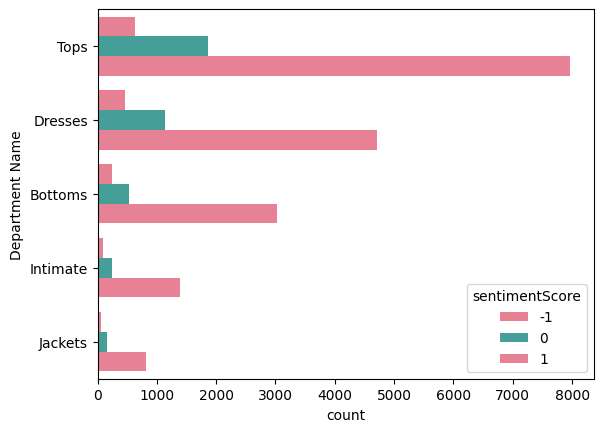

In [6]:
# Clothings that get the most positive reviews
sns.countplot(data=data, y='Department Name', hue='sentimentScore', palette='husl', order=data['Department Name'].value_counts().iloc[:5].index)

In [7]:
# Convert 'Review Text' column to strings, handling NaN values
positive_reviews = data[data['sentiment'] == 'Positive']['Review Text'].astype(str)

# Join the strings and split into words
positive_words = pd.Series(' '.join(positive_reviews).split())


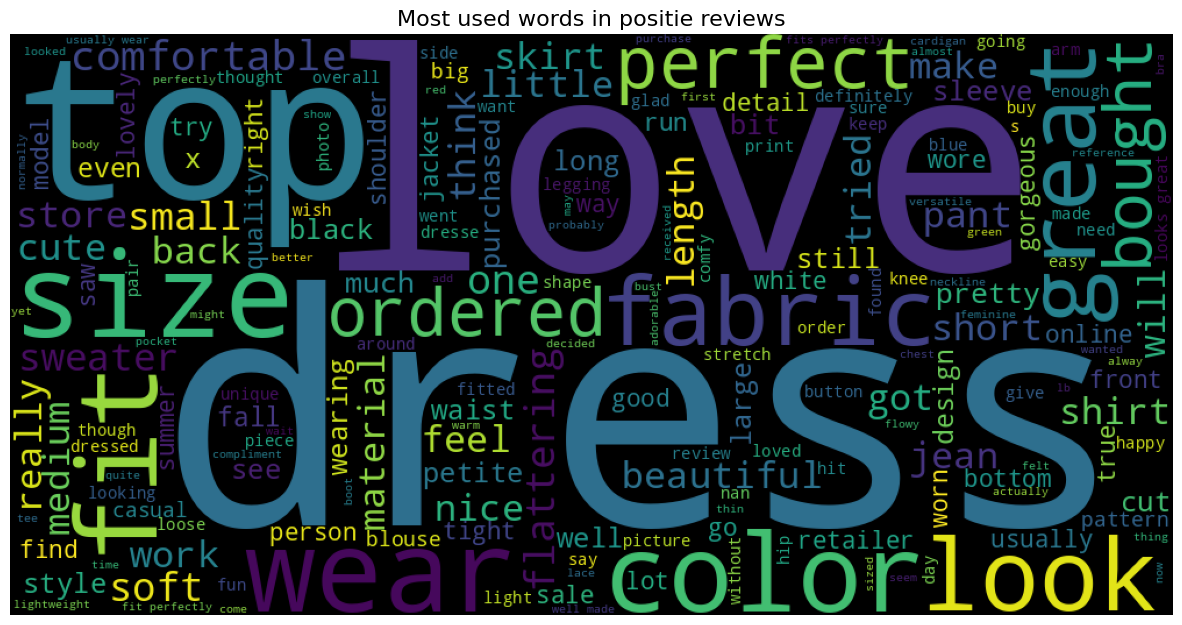

In [8]:
# Plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(positive_words))

plt.figure(figsize = (15,8))

plt.imshow(wordcloud)
plt.title("Most used words in positie reviews", size = 16)

plt.axis("off")
plt.show()

In [9]:
# Convert 'Review Text' column to strings, handling NaN values
negative_reviews = data[data['sentiment'] == 'Negative']['Review Text'].astype(str)

# Join the strings and split into words
negative_words = pd.Series(' '.join(negative_reviews).split())

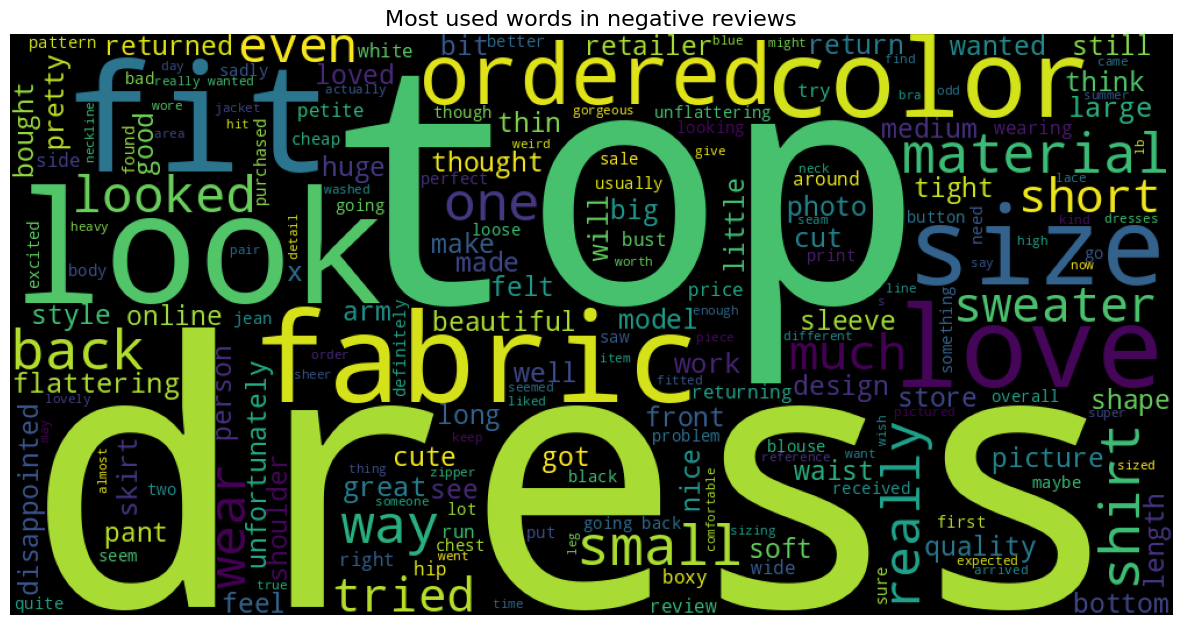

In [10]:
# Plot word cloud
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(negative_words))

plt.figure(figsize = (15,8))

plt.imshow(wordcloud)
plt.title("Most used words in negative reviews", size = 16)

plt.axis("off")
plt.show()

In [11]:
# Text Processing

#1 Clean text Function
def cleanText(text:str):
  text = str(text)
  text = text.lower()
  text = text.strip()

  text = re.sub(' \d+', ' ', text)
  text = re.compile('<.*?>').sub(' ', text)
  text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
  text = re.sub('\s+', ' ', text)

  text = text.strip()

  return text

In [12]:
#2 Remove Stopwords
def removeStopwords(text:str):
    text = str(text)
    filteredSentence = []

    stopWords = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stopWords:
            filteredSentence.append(w)
    text = " ".join(filteredSentence)

    return text

In [17]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [13]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
#3 Lemmatize Function
def lemmatize(text:str):
    text = str(text)

    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatizedSentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    wordPosTags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(wordPosTags):
        lemmatizedSentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatizedText = " ".join(lemmatizedSentence)

    return lemmatizedText

In [18]:
# Apply three of them to our dataset
# Clean text
data['text'] = data['Review Text'].apply(cleanText)

# Remove Stopwords
data['text'] = data['text'].apply(removeStopwords)

# Lemmatize
data['text'] = data['text'].apply(lemmatize)

In [21]:
# Test
import random
idx = random.choice(range(len(data)))

print(f"The original text: \n{data['Review Text'].iloc[idx]}\n")
print(f"The cleaned text: \n{data['text'].iloc[idx]}")

The original text: 
I love this skirt, wanted to order it from the moment it was new and took em a while to decide to do so (when i saw it was almost sold out in my size, which it is now). another thing is it doesn't come in petite - boohoo.
anyway, ordered the 0 (smallest size) for my 26.5 in waist - didn't have any trouble with the waist being too tight, like some other reviewers. it fit really well and comfortably. sits at the natural waist, so the hem isn't too crazy low on me. fine for heels (would be so cute

The cleaned text: 
i love skirt want order from moment be new take em while decide do so when i saw be almost sell out in my size which now another thing doesn t come in petite boohoo anyway order small size for my 5 in waist didn t have any trouble with waist be too tight like some other reviewer fit really well comfortably sit at natural waist so hem isn t too crazy low on me fine for heel would be so cute


In [20]:
data.to_csv('cleanedDataset.csv', index = False)

In [22]:
# New dataframe
data = pd.read_csv('cleanedDataset.csv')

In [23]:
# Data type
data.dtypes

Clothing ID                 int64
Age                         int64
Title                      object
Review Text                object
Rating                      int64
Recommended IND             int64
Positive Feedback Count     int64
Division Name              object
Department Name            object
Class Name                 object
sentimentScore              int64
sentiment                  object
text                       object
dtype: object

In [24]:
# Check if there are some missing values
data[data['text'].isnull()]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,sentimentScore,sentiment,text
92,861,23,NaN,NaN,5,1,0,General Petite,Tops,Knits,1,Positive,NaN
93,1081,31,NaN,NaN,5,1,0,General,Dresses,Dresses,1,Positive,NaN
98,1133,50,NaN,NaN,5,1,0,General,Jackets,Outerwear,1,Positive,NaN
135,861,35,NaN,NaN,4,1,0,General Petite,Tops,Knits,1,Positive,NaN
142,1126,35,NaN,NaN,5,1,0,General,Jackets,Outerwear,1,Positive,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23258,862,35,NaN,NaN,4,1,0,General,Tops,Knits,1,Positive,NaN
23301,862,52,NaN,NaN,5,1,0,General,Tops,Knits,1,Positive,NaN
23303,823,46,NaN,NaN,5,1,0,General,Tops,Blouses,1,Positive,NaN
23470,1104,39,NaN,NaN,5,1,0,General Petite,Dresses,Dresses,1,Positive,NaN


In [25]:
# drop null values
data.dropna(inplace = True)
data.isnull().sum()

Clothing ID                0
Age                        0
Title                      0
Review Text                0
Rating                     0
Recommended IND            0
Positive Feedback Count    0
Division Name              0
Department Name            0
Class Name                 0
sentimentScore             0
sentiment                  0
text                       0
dtype: int64

In [26]:
# Take the text column and Recommend IND save it to a new Dataframe

sentimentText = data[["text","Recommended IND"]]
sentimentText.head()

,text,Recommended IND
2,i have such high hope for dress really want wo...,0
3,i love love love jumpsuit s fun flirty fabulou...,1
4,shirt very flatter all due adjustable front ti...,1
5,i love tracy reese dress but one not for very ...,0
6,i aded in my basket at hte last mintue see wha...,1


In [27]:
# Check Data Proportions

sentimentText['Recommended IND'].value_counts()

1    14980
0     3408
Name: Recommended IND, dtype: int64

In [28]:
#Try undersample from new dataframe
target_count = sentimentText['Recommended IND'].value_counts()
negativeClass = sentimentText[sentimentText['Recommended IND'] == 0]
positiveClass = sentimentText[sentimentText['Recommended IND'] == 1].sample(n=
sentimentText['Recommended IND'].value_counts()[0], random_state=123)
dataBalance= pd.concat([positiveClass,negativeClass])
dataBalance.head()

,text,Recommended IND
700,i get in blue also in white both size medium s...,1
13051,i be 3 lb i order on whim i m so happy i do be...,1
22080,what beautiful harbinger of spring blouse so l...,1
6307,buy in pink for wed summer dress detail note a...,1
10192,excited get sweater i m c usually wear size bl...,1


In [29]:
dataBalance['Recommended IND'].value_counts()

1    3408
0    3408
Name: Recommended IND, dtype: int64

In [34]:
# TF-IDF
# a technique to quantify words in a set of documents.
vect = TfidfVectorizer(max_features=700)
vect.fit(dataBalance['text'])
features = vect.transform(dataBalance['text'])


In [35]:
tfIdf = pd.DataFrame(features.toarray(), columns=vect.get_feature_names_out())
tfIdf.head()

,10,able,about,above,absolutely,across,actually,add,addition,adorable,...,xl,xs,xx,year,yellow,yet,you,your,zip,zipper
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.173076,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.156795,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.206677,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.205995,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [36]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(tfIdf, dataBalance['Recommended IND'], test_size=0.2, random_state=42)

In [37]:
# Model Naive Bayes
def modeling(Model, xTrain = x_train, xTest = x_test):
    # Instantiate the classifier: model
    model = Model

    # Fitting classifier to the Training set (all features)
    model.fit(xTrain, y_train)

    global y_pred
    # Predicting the Test set results
    y_pred = model.predict(xTest)

    # Assign f1 score to a variable
    print(classification_report(y_test, y_pred))
    print ('AUC ',roc_auc_score(y_test, y_pred))
    print('Precision : ', precision_score(y_test, y_pred))
    print('F-1 Score : ', f1_score(y_test, y_pred, average='macro'))
    print('Recall :', recall_score(y_test, y_pred))

    #cm = confusion_matrix(y_test, y_pred)
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)
    plt.figure(figsize = (8,8))

    sns.heatmap(confusion_matrix, annot=True,annot_kws={"fontsize":14}, fmt='.2f', cmap='Greens').set_title('Confusion Matrix for Naive Bayes')

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       675
           1       0.91      0.84      0.87       689

    accuracy                           0.88      1364
   macro avg       0.88      0.88      0.88      1364
weighted avg       0.88      0.88      0.88      1364

AUC  0.877936891899156
Precision :  0.9090909090909091
F-1 Score :  0.8774758260194166
Recall : 0.841799709724238


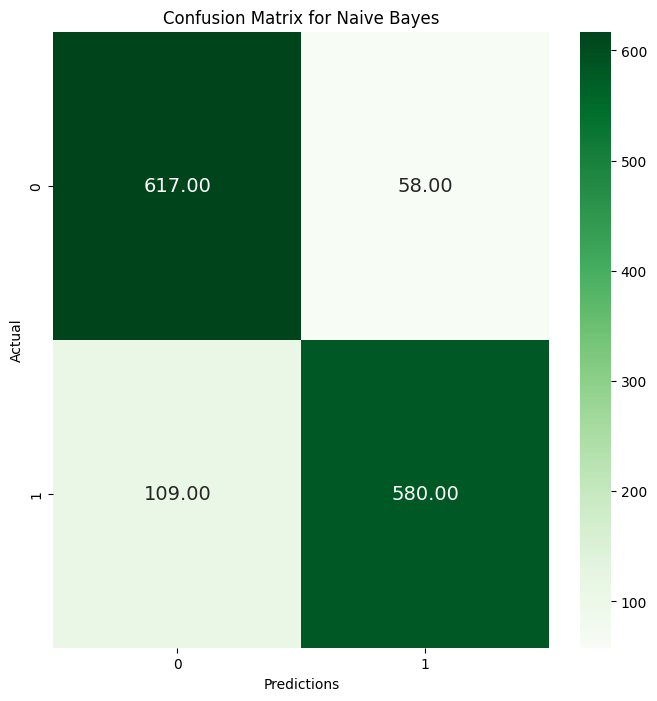

In [38]:
# Naive Bayes
modeling(MultinomialNB())

In [39]:
# Model K-Nearest Neighbors (KNN)
def modeling_knn(knn_model, xTrain=x_train, xTest=x_test):

    # Instantiate the classifier
    model = knn_model

    # Fitting classifier to the Training set (all features)
    model.fit(xTrain, y_train)

    # Predicting the Test set results
    y_pred = model.predict(xTest)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Print AUC score
    print('AUC:', roc_auc_score(y_test, y_pred))
    print('Precision : ', precision_score(y_test, y_pred))
    print('F-1 Score : ', f1_score(y_test, y_pred, average='macro'))
    print('Recall :', recall_score(y_test, y_pred))

    # Generate confusion matrix
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"fontsize": 14}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix for KNN')
    plt.show()


              precision    recall  f1-score   support

           0       0.74      0.83      0.78       675
           1       0.81      0.72      0.76       689

    accuracy                           0.77      1364
   macro avg       0.78      0.77      0.77      1364
weighted avg       0.78      0.77      0.77      1364

AUC: 0.7725646401118098
Precision :  0.8098360655737705
F-1 Score :  0.771475177923913
Recall : 0.7169811320754716


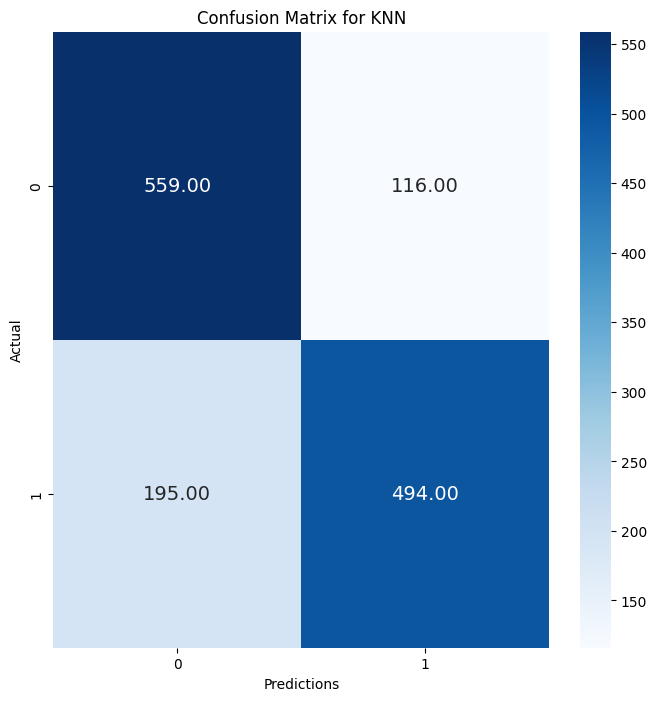

In [40]:
knn_model = KNeighborsClassifier(n_neighbors=5)  #  with 5 neighbors
modeling_knn(knn_model)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       675
           1       0.89      0.86      0.88       689

    accuracy                           0.88      1364
   macro avg       0.88      0.88      0.88      1364
weighted avg       0.88      0.88      0.88      1364

AUC: 0.8791926033435468
Precision :  0.8933933933933934
F-1 Score :  0.8790269912895778
Recall : 0.8635703918722787


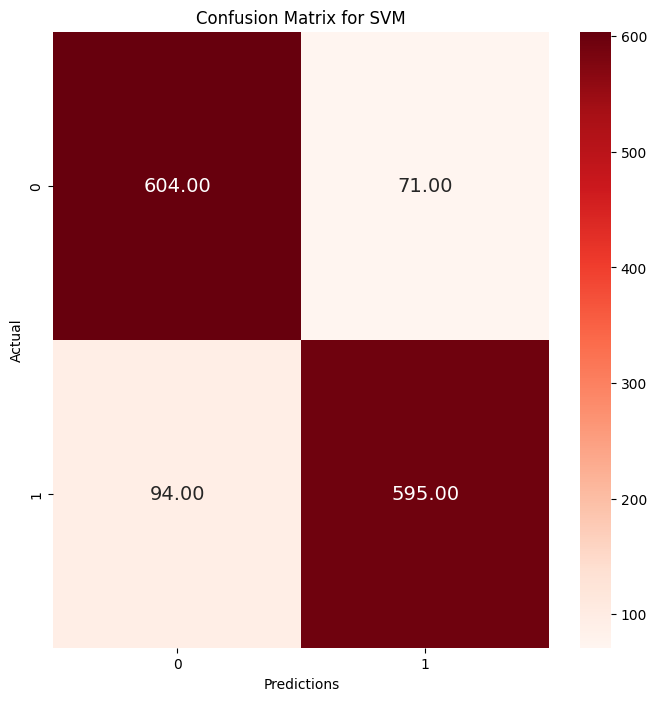

AUC: 0.8791926033435468


In [41]:
def modeling_svm(svm_model, xTrain=x_train, xTest=x_test, yTrain=y_train, yTest=y_test):
    try:
        # Fitting classifier to the Training set
        svm_model.fit(xTrain, yTrain)

        # Predicting the Test set results
        y_pred = svm_model.predict(xTest)

        # Print classification report
        print("Classification Report:")
        print(classification_report(yTest, y_pred))

        # Print AUC score
        auc = roc_auc_score(yTest, y_pred)
        print('AUC:', auc)
        print('Precision : ', precision_score(y_test, y_pred))
        print('F-1 Score : ', f1_score(y_test, y_pred, average='macro'))
        print('Recall :', recall_score(y_test, y_pred))

        # Generate confusion matrix
        confusion_matrix = pd.crosstab(index=yTest, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)

        # Plot confusion matrix
        plt.figure(figsize=(8, 8))
        sns.heatmap(confusion_matrix, annot=True, annot_kws={"fontsize": 14}, fmt='.2f', cmap='Reds').set_title('Confusion Matrix for SVM')
        plt.show()

        return auc
    except Exception as e:
        print("An error occurred during model training:", e)
        return None

# SVM Usage with Gamma 1.0
svm_model = SVC(kernel='linear', C=1.0)
auc = modeling_svm(svm_model)
if auc is not None:
    print("AUC:", auc)


In [42]:
def modeling_random_forest(rf_model, xTrain=x_train, xTest=x_test):
    # Instantiate the classifier
    model = rf_model

    # Fitting classifier to the Training set (all features)
    model.fit(xTrain, y_train)

    # Predicting the Test set results
    y_pred = model.predict(xTest)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print AUC score
    print('AUC:', roc_auc_score(y_test, y_pred))
    print('Precision : ', precision_score(y_test, y_pred))
    print('F-1 Score : ', f1_score(y_test, y_pred, average='macro'))
    print('Recall :', recall_score(y_test, y_pred))

    # Generate confusion matrix
    confusion_matrix = pd.crosstab(index=y_test, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"fontsize": 14}, fmt='.2f', cmap='Greens').set_title('Confusion Matrix for Random Forest')
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       675
           1       0.87      0.82      0.85       689

    accuracy                           0.85      1364
   macro avg       0.85      0.85      0.85      1364
weighted avg       0.85      0.85      0.85      1364

AUC: 0.8507251518572273
Precision :  0.8736517719568567
F-1 Score :  0.8503855211794691
Recall : 0.8229317851959361


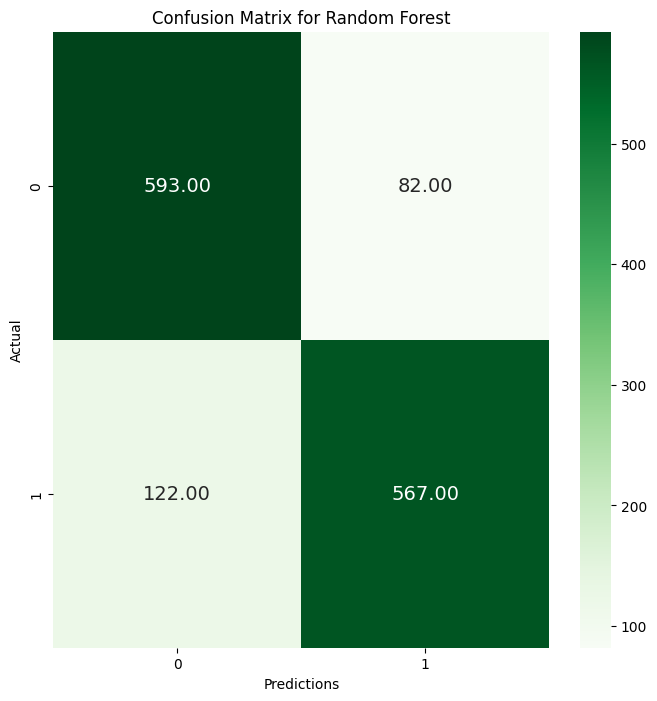

In [43]:
rf_model = RandomForestClassifier(n_estimators=100)  # with 100 trees
modeling_random_forest(rf_model)

In [44]:
def modeling_logistic_regression(lr_model, xTrain=x_train, xTest=x_test, yTrain=y_train, yTest=y_test):

    # Fitting classifier to the Training set
    lr_model.fit(xTrain, yTrain)

    # Predicting the Test set results
    y_pred = lr_model.predict(xTest)

    # Hitung F-1 Score Macro, Precission, Recall

    # Print classification report
    print("Classification Report:")
    print(classification_report(yTest, y_pred))

    # Print AUC score
    auc = roc_auc_score(yTest, y_pred)
    print('AUC:', auc)
    print('Precision : ', precision_score(y_test, y_pred))
    print('F-1 Score : ', f1_score(y_test, y_pred, average='macro'))
    print('Recall :', recall_score(y_test, y_pred))

    # Generate confusion matrix
    confusion_matrix = pd.crosstab(index=yTest, columns=np.round(y_pred), rownames=['Actual'], colnames=['Predictions']).astype(int)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    sns.heatmap(confusion_matrix, annot=True, annot_kws={"fontsize": 14}, fmt='.2f', cmap='Blues').set_title('Confusion Matrix for Logistic Regression')
    plt.show()

    return auc

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       675
           1       0.89      0.86      0.88       689

    accuracy                           0.88      1364
   macro avg       0.88      0.88      0.88      1364
weighted avg       0.88      0.88      0.88      1364

AUC: 0.8762446917163897
Precision :  0.8892215568862275
F-1 Score :  0.8760964434891185
Recall : 0.8621190130624092


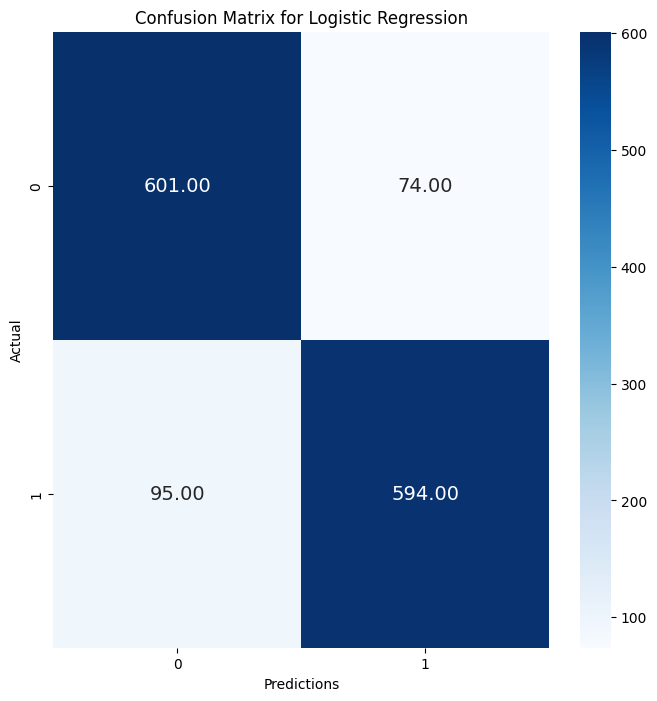

AUC: 0.8762446917163897


In [45]:
lr_model = LogisticRegression()
auc = modeling_logistic_regression(lr_model)
if auc is not None:
    print("AUC:", auc)